# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [85]:
import glob
import calendar

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from geocat.viz import TaylorDiagram

import spatial_selection

In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [43]:
nrm_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_clusters/NRM_clusters.shp')
nrm_clusters

,OBJECTID,Shape_Leng,Shape_Area,code,label,geometry
0,1,43.872364,28.309947,CS,Central Slopes,"POLYGON ((147.95551 -24.87828, 147.95583 -24.8..."
1,2,56.117544,34.176299,EC,East Coast,"POLYGON ((150.74778 -22.17931, 150.75589 -22.2..."
2,4,45.869349,45.299310,MB,Murray Basin,"POLYGON ((145.74766 -32.21733, 145.75055 -32.2..."
3,5,119.284033,124.655757,MN,Monsoonal North,"MULTIPOLYGON (((119.10713 -19.52547, 119.10875..."
4,6,137.457553,407.116072,R,Rangelands,"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
5,7,59.887218,23.431035,SS,Southern Slopes,"MULTIPOLYGON (((144.35074 -40.52507, 144.34898..."
6,8,87.137068,50.647491,SSWF,Southern and South-Western Flatlands,"MULTIPOLYGON (((137.24178 -36.44855, 137.23945..."
7,9,45.896712,19.503388,WT,Wet Tropics,"MULTIPOLYGON (((148.82846 -19.98136, 148.88120..."


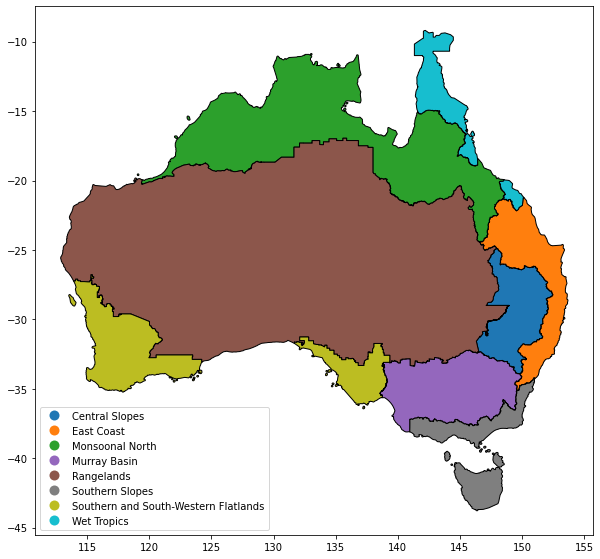

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [44]:
nrm_sub_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_sub_clusters/NRM_sub_clusters.shp')
nrm_sub_clusters

,OBJECTID,C_code,C_Label,code,label,geometry
0,9,WT,Wet Tropics,WT,Wet Tropics,"MULTIPOLYGON (((150.17258 -21.24859, 150.09178..."
1,0,R,Rangelands,RN,Rangelands (North),"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
2,0,MN,Monsoonal North,MNE,Monsoonal North (East),"POLYGON ((146.42400 -18.40860, 146.44167 -18.4..."
3,0,MN,Monsoonal North,MNW,Monsoonal North (West),"MULTIPOLYGON (((133.03730 -10.85283, 133.03836..."
4,0,EC,East Coast,ECS,East Coast (South),"POLYGON ((151.03053 -34.27589, 151.03053 -34.2..."
5,0,CS,Central Slopes,CS,Central Slopes,"POLYGON ((147.95700 -24.87855, 147.95711 -24.8..."
6,0,MB,Murray Basin,MB,Murray Basin,"MULTIPOLYGON (((140.96606 -38.10852, 140.96606..."
7,0,SSWF,Southern and South Western Flatlands,SSWFW,Southern and South Western Flatlands (West),"MULTIPOLYGON (((121.99574 -34.52416, 121.99376..."
8,0,SSWF,Southern and South Western Flatlands,SSWFE,Southern and South Western Flatlands (East),"MULTIPOLYGON (((137.32870 -36.29796, 137.32916..."
9,0,SS,Southern Slopes,SSVE,Southern Slopes (Vic/NSW East),"MULTIPOLYGON (((147.09424 -39.19847, 147.06241..."


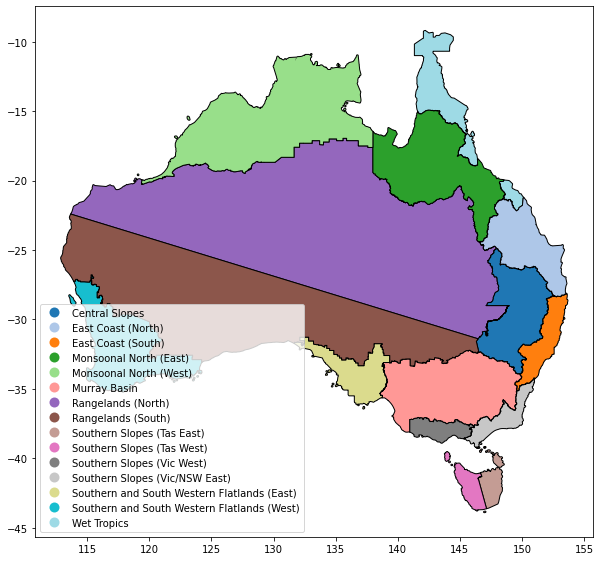

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_sub_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    cmap='tab20',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [16]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## Get NorESM2-MM data

In [17]:
noresm_dates = ['19900101-19991231', '20000101-20091231', '20100101-20141231']
noresm_tmax_files = [f'/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_{dates}.nc' for dates in noresm_dates]
noresm_tmax_files

['/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/tasmax/gn/v20191108/tasmax_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc']

In [18]:
noresm_ds = xr.open_mfdataset(noresm_tmax_files)
noresm_ds = noresm_ds.sel({'time': slice(start_date, end_date)})
noresm_ds = noresm_ds.drop('height')

In [19]:
noresm_annual_clim = noresm_ds.mean('time', keep_attrs=True)
noresm_monthly_clim = noresm_ds.groupby('time.month').mean('time', keep_attrs=True)

## Get AGCD data

In [20]:
agcd_years = np.arange(1995, 2015, 1)
agcd_tmax_files = [f'/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_{year}0101-{year}1231_daily.nc' for year in agcd_years]
agcd_tmax_files

['/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19950101-19951231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19960101-19961231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19970101-19971231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19980101-19981231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_19990101-19991231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20000101-20001231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20010101-20011231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20020101-20021231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20030101-20031231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20040101-20041231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20050101-20051231_daily.nc',
 '/g/data/xv83/agcd-csiro/tmax/tmax_AGCD-CSIRO_r005_20060101-20061231_daily.nc',
 '/g/data/xv83/agcd-csiro/tm

In [21]:
agcd_ds = xr.open_mfdataset(agcd_tmax_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [22]:
agcd_ds

<xarray.Dataset>
Dimensions:    (lon: 886, time: 7305, bnds: 2, lat: 691)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * time       (time) datetime64[ns] 1995-01-01T09:00:00 ... 2014-12-31T09:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (time, lon, bnds) float32 dask.array<chunksize=(365, 886, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float32 dask.array<chunksize=(365, 691, 2), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax       (time, lat, lon) float32 dask.array<chunksize=(365, 691, 886), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 17:20:16 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [23]:
agcd_annual_clim = agcd_ds.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [24]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  2min 11.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  1min 38.2s


In [25]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1min 38.9s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  1.3s
[########################################] | 100% Completed |  1min 36.8s


In [26]:
noresm_regridder = xe.Regridder(noresm_ds, agcd_ds, "bilinear")

In [27]:
noresm_annual_clim = noresm_regridder(noresm_annual_clim)
noresm_monthly_clim = noresm_regridder(noresm_monthly_clim)

In [28]:
noresm_annual_clim = spatial_selection.select_shapefile_regions(noresm_annual_clim, aus_shape)

[########################################] | 100% Completed | 10.4s
[########################################] | 100% Completed |  8.4s


In [29]:
noresm_monthly_clim = spatial_selection.select_shapefile_regions(noresm_monthly_clim, aus_shape)

[########################################] | 100% Completed |  9.1s
[########################################] | 100% Completed |  8.4s


## Mean bias

In [30]:
noresm_annual_clim = noresm_annual_clim.compute()

[########################################] | 100% Completed |  8.1s


In [31]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  1min 40.3s


In [32]:
noresm_annual_clim['tasmax'] = noresm_annual_clim['tasmax'] - 273.13
noresm_annual_clim['tasmax'].attrs['units'] = 'C'

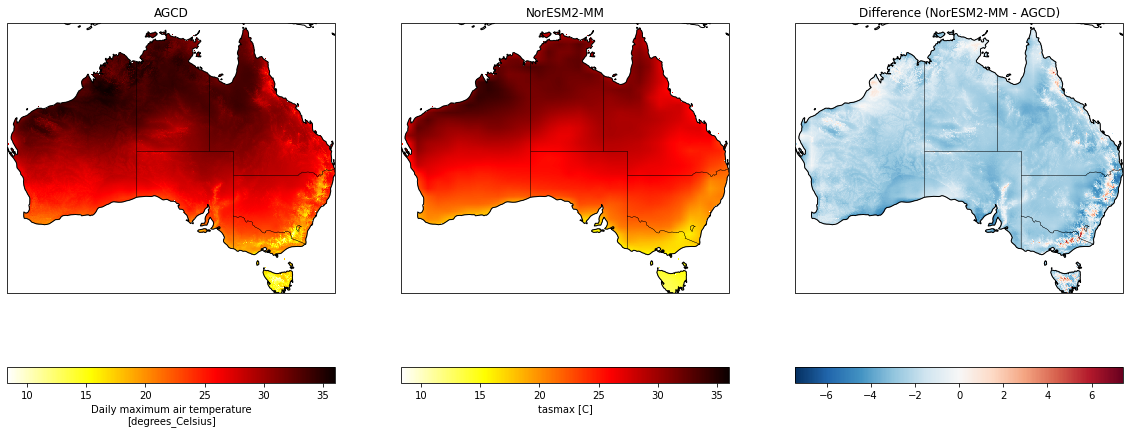

In [34]:
fig = plt.figure(figsize=[20, 9])

noresm_max = np.nanmax(noresm_annual_clim['tasmax'].values)
agcd_max = np.nanmax(agcd_annual_clim['tmax'].values)
vmax = np.nanmax([noresm_max, agcd_max])

noresm_min = np.nanmin(noresm_annual_clim['tasmax'].values)
agcd_min = np.nanmin(agcd_annual_clim['tmax'].values)
vmin = np.nanmin([noresm_min, agcd_min])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
agcd_annual_clim['tmax'].plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    vmax=vmax,
    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax1.set_title('AGCD')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
noresm_annual_clim['tasmax'].plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='hot_r',
    vmax=vmax,
    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax2.set_title('NorESM2-MM')

diff = noresm_annual_clim['tasmax'] - agcd_annual_clim['tmax']
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
diff.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
#    cmap='hot_r',
#    vmax=vmax,
#    vmin=vmin,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax3.set_title('Difference (NorESM2-MM - AGCD)')

for ax in [ax1, ax2, ax3]:
    #ax.add_geometries(nrm_shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
    #ax.spines['top'].set_visible(False)

#plt.suptitle(title)
plt.show()

## Temporal 

In [35]:
noresm_monthly_clim = noresm_monthly_clim.compute()

[########################################] | 100% Completed |  8.9s


In [36]:
agcd_monthly_clim = agcd_monthly_clim.compute()

[########################################] | 100% Completed |  1min 38.1s


In [37]:
noresm_monthly_clim['tasmax'] = noresm_monthly_clim['tasmax'] - 273.13
noresm_monthly_clim['tasmax'].attrs['units'] = 'C'

In [38]:
temporal_corr = xr.corr(noresm_monthly_clim['tasmax'], agcd_monthly_clim['tmax'], dim='month') 

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [39]:
noresm_temporal_std = noresm_monthly_clim['tasmax'].std(dim='month', keep_attrs=True)
agcd_temporal_std = agcd_monthly_clim['tmax'].std(dim='month', keep_attrs=True)
std_ratio = noresm_temporal_std / agcd_temporal_std

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


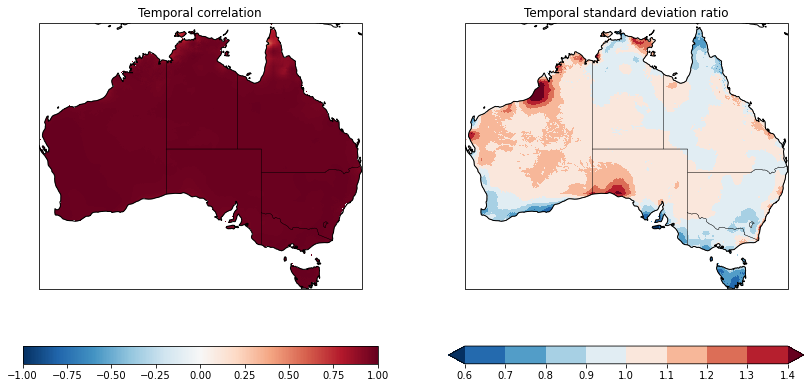

In [42]:
fig = plt.figure(figsize=[14, 7])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
temporal_corr.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=1,
    vmin=-1,
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax1.set_title('Temporal correlation')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
std_ratio.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal'}
)
ax2.set_title('Temporal standard deviation ratio')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
#plt.suptitle(title)
plt.show()

In [56]:
noresm_monthly_clim_nrm_clusters = spatial_selection.select_shapefile_regions(
noresm_monthly_clim,
    nrm_clusters,
    agg='weighted_mean',
    header='label'
)
noresm_monthly_clim_nrm_clusters

<xarray.Dataset>
Dimensions:  (month: 12, region: 8)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) <U36 'Central Slopes' 'East Coast' ... 'Wet Tropics'
Data variables:
    tasmax   (month, region) float32 30.48 29.27 29.08 ... 19.27 27.24 31.15
Attributes:
    regrid_method:  bilinear

In [52]:
agcd_monthly_clim_nrm_clusters = spatial_selection.select_shapefile_regions(
    agcd_monthly_clim,
    nrm_clusters,
    agg='weighted_mean',
    header='label'
)
agcd_monthly_clim_nrm_clusters

<xarray.Dataset>
Dimensions:   (month: 12, region: 8, bnds: 2)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) <U36 'Central Slopes' 'East Coast' ... 'Wet Tropics'
Dimensions without coordinates: bnds
Data variables:
    lon_bnds  (month, bnds, region) float32 149.4 150.6 144.2 ... 122.1 143.9
    lat_bnds  (month, bnds, region) float32 -29.5 -26.84 ... -32.15 -14.88
    tmax      (month, region) float32 32.98 31.04 31.9 ... 21.5 29.66 33.32
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 17:20:16 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily maximum temperature station data...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

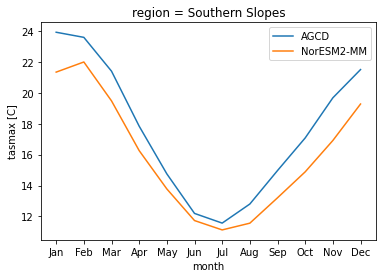

In [91]:
agcd_monthly_clim_nrm_clusters['tmax'].sel({'region': 'Southern Slopes'}).plot(label='AGCD')
noresm_monthly_clim_nrm_clusters['tasmax'].sel({'region': 'Southern Slopes'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.show()

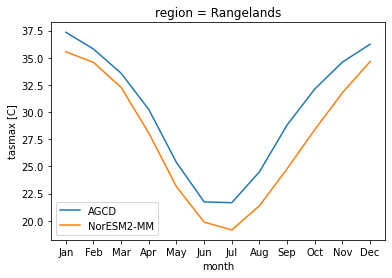

In [92]:
agcd_monthly_clim_nrm_clusters['tmax'].sel({'region': 'Rangelands'}).plot(label='AGCD')
noresm_monthly_clim_nrm_clusters['tasmax'].sel({'region': 'Rangelands'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.show()

## Spatial

In [70]:
noresm_spatial_corr = xr.corr(noresm_monthly_clim['tasmax'], agcd_monthly_clim['tmax'], dim=['lat', 'lon']) 

In [71]:
noresm_spatial_corr

<xarray.DataArray (month: 12)>
array([0.95901436, 0.94880801, 0.96549457, 0.97792465, 0.98265758,
       0.98426885, 0.98312846, 0.97945217, 0.97245568, 0.97799131,
       0.97391681, 0.96636761])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [76]:
noresm_spatial_corr_ave = float(noresm_spatial_corr.mean('month'))
noresm_spatial_corr_ave

0.9726233376657308

In [69]:
noresm_spatial_std = noresm_monthly_clim['tasmax'].std(dim=['lat', 'lon'], keep_attrs=True)
noresm_spatial_std

<xarray.DataArray 'tasmax' (month: 12)>
array([3.9732084, 3.5923245, 3.7906225, 4.308785 , 4.348892 , 4.528488 ,
       4.6746225, 5.064253 , 5.3454604, 5.4123554, 5.0357866, 4.6703925],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:    C

In [75]:
noresm_spatial_std_ave = float(noresm_spatial_std.mean('month'))
noresm_spatial_std_ave

4.562098979949951

In [78]:
agcd_spatial_std = agcd_monthly_clim['tmax'].std(dim=['lat', 'lon'], keep_attrs=True)
agcd_spatial_std

<xarray.DataArray 'tmax' (month: 12)>
array([3.7477539, 3.3903375, 3.6081398, 4.2214284, 4.4290967, 4.6771975,
       5.0107775, 5.105417 , 5.460762 , 5.318214 , 4.6511726, 4.159191 ],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:                 air_temperature
    long_name:                     Daily maximum air temperature
    units:                         degrees_Celsius
    cell_methods:                  time: maximum
    analysis_version_number:       3.51
    number_of_stations_reporting:  584
    source:                        Interpolated surface observations
    frequency:                     daily
    length_scale_for_analysis:     250.0
    analysis_time:                 2010-10-07 02:58:27 UTC

In [79]:
agcd_spatial_std_ave = float(agcd_spatial_std.mean('month'))
agcd_spatial_std_ave

4.481624126434326

In [81]:
noresm_spatial_std_ratio = noresm_spatial_std_ave / agcd_spatial_std_ave
noresm_spatial_std_ratio

1.017956627161335

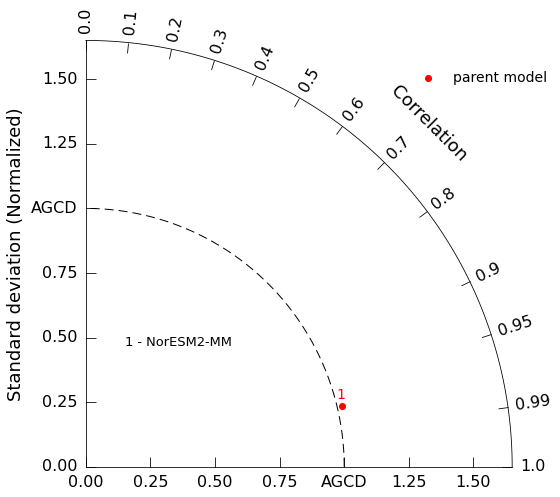

In [84]:
# parent models
parent_std_ratios = [noresm_spatial_std_ratio]
parent_corrs = [noresm_spatial_corr_ave]

# CCAM data
ccam_std_ratios = []
ccam_corrs = []

# BARPA data
barpa_std_ratios = []
barpa_corrs = []

# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(8, 8))
dia = TaylorDiagram(fig=fig, label='AGCD')

# Add parent models to Taylor diagram
dia.add_model_set(
    parent_std_ratios,
    parent_corrs,
    color='red',
    marker='o',
    label='parent model'
)

namearr = ['NorESM2-MM']
dia.add_model_name(namearr)
dia.add_legend()
plt.show()